In [1]:
from google.colab import drive
import numpy as np
import os
import networkx as nx
from matplotlib import pyplot as plt
import itertools
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install transformers
! pip install --upgrade pip
! pip install sentencepiece
! pip install umap-learn

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 3.3MB 29.1MB/s 
     |████████████████████████████████| 870kB 28.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f3b2c2f039a76cd43ae65949613abbaa651af51ad55c2a726ab69e7324571966
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.5MB 4.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.2 MB 5.5 MB/s 
     |████████████████████████████████| 80 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 7.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=d5c9705b84f602d72db66e720c5feb0ba8a2164c6dfd7492603e94f3707d3f3e
  Stored in directory: /root/.cache/pip

In [3]:
from transformers import AutoTokenizer, AutoModelWithLMHead
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import textwrap
import spacy
import en_core_web_sm
from tqdm import tqdm

In [4]:
% cd /content/gdrive/My Drive/aml

/content/gdrive/My Drive/aml


In [5]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")
device='cuda:0'

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:762: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [6]:
def get_emotion(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')
  output = model.generate(input_ids=input_ids, max_length=2)
  print(output)
  dec = [tokenizer.decode(ids) for ids in output]
  # print(dec)
  label = dec[0]
  return label

In [7]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    # self.data_column = "text"
    # self.class_column = "emotion"
    self.data = pd.read_csv(self.path, header=None, engine="python")
    print(len(self.data))
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    # self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    # target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    # target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      # input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      input_ = self.data.loc[idx][0]
      
      input_ = input_ + ' </s>'
      # print(self.data.loc[idx])
       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      # tokenized_targets = self.tokenizer.batch_encode_plus(
      #     [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      # )

      self.inputs.append(tokenized_inputs)
      # self.targets.append(tokenized_targets)

emotions = ["sadness", "joy", "love", "anger", "fear", "surprise", "positive"]

def one_hot_emotion(emo):
  out = np.zeros(7)
  idx = emotions.index(emo)
  out[idx] = 1
  return out

In [8]:
# get_emotion("i feel as if i havent blogged in ages are at least truly blogged i am doing an update cute") # Output: 'joy'
months = ["jan", "feb", "apr", "jun", 'aug', 'dec']

In [ ]:
month_data = {}
month_emos = {}
model = model.to(device)
for month in months[:1]:
  print("Mining emotions for month ", month)
  dataset = EmotionDataset(tokenizer, 'aml', month, 128)
  loader = DataLoader(dataset, batch_size=512, shuffle=True)
  it = iter(loader)
  data = []
  emos = []
  cnt = 0
  while True:
      try:
          batch = next(it)
      except StopIteration:
          break  # Iterator exhausted: stop the loop
      else:
          input_ids =  batch['source_ids'].to(device)
          attention_mask = batch['source_mask'].to(device)
          outs = model.generate(input_ids= input_ids, 
                                        attention_mask=attention_mask,
                                        max_length=2)
          dec = [tokenizer.decode(ids) for ids in outs]
          texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
          data += texts
          emos.append
          for i in tqdm(range(len(texts))):
            c = texts[i]
            emos.append(dec[i])
          print(emos[-1])
          print(data[-1])
  month_data[month] = data
  month_emos[month] = emos
  pd.DataFrame(data, index=None).to_csv(month + "_data" + ".csv", sep='\n', index=None, header=None)
  pd.DataFrame(emos, index=None).to_csv(month + "_emos" + ".csv", sep='\n', index=None, header=None)

In [ ]:
class SpacyNER:
    def ner(self,doc):    
        nlp = en_core_web_sm.load()
        doc = nlp(doc)
        # doc.max_length = 10000000
        return [(X.text, X.label_) for X in doc.ents]
    
    def ner_to_dict(self,ner):
        """
        Expects ner of the form list of tuples 
        """
        ner_dict = {}
        for tup in ner:
            ner_dict[tup[0]] = tup[1]
        return ner_dict
    
    def display(self,ner):
        print(ner)
        print("\n")

def split(lst, sep):
	size = len(lst)
	idx_list = [idx + 1 for idx, val in enumerate(lst) if val == sep]
	res = [lst[i: j] for i, j in
	        zip([0] + idx_list, idx_list + 
	        ([size] if idx_list[-1] != size else []))]
	return res

In [ ]:
print("\nusing Spacy for NER\n")
spacy_ner = SpacyNER()
nlp = spacy.load('en_core_web_sm') 
# nlp.max_length = 10000000 #or any large value, as long as you don't run out of RAM
# doc = nlp(doc)
doc = month_data["jan"][1]
print(doc)
named_entities = spacy_ner.ner(doc)
spacy_ner.display(named_entities)
named_entities = spacy_ner.ner_to_dict(named_entities)
print(named_entities)
print(month_emos["jan"][1])

## Prepare Text for NER

In [ ]:
month_data = {}
month_emos = {}

for month in months:
  # month_data[month] = []
  f = open(month + "_data.csv", "r")
  lines = f.readlines()
  for i in range(len(lines)):
    # add dummy token to speed up NER
    lines[i] = lines[i].split("</s>")[0]
    lines[i] = lines[i].replace("<unk>", "")
    lines[i] += ". No 10%."
  # month_data[month].append("  ".join(lines))
  month_data[month] = lines

  f = open(month + "_emos.csv", "r")
  lines = f.readlines()
  for i in range(len(lines)):
    lines[i] = lines[i].replace("<pad> ", "").replace("\n", "")
  month_emos[month] = lines

## Doing NER (batch wise)

In [ ]:
# Find all named entities for all months
named_entity_month = {}

for month in months:
  vertices[month] = {}
  print("Doing NER for month: " + month)
  l = 0
  named_entities = []
  while l < len(month_data[month]):
    lines = month_data[month][l:l+5000]
    concat_lines = "  ".join(lines)
    ne = spacy_ner.ner(concat_lines)
    res = split(ne, ('No 10%', 'PERCENT'))
    named_entities.append(res)
    l += 5000
  named_entity_month[month] = list(itertools.chain.from_iterable(named_entities))

### Doing NER (line wise)

In [ ]:
def get_ne_emos(month, CHUNK=100):
  named_entity_month = {}
  # month = 'dec'
  vertices[month] = {}
  print("Doing NER for month: " + month)
  l = 0
  named_entities = []
  emos = []
  CHUNK = 100
  while l < len(month_data[month]):
    lines = month_data[month][l:l+CHUNK]
    concat_lines = "  ".join(lines)
    ne = spacy_ner.ner(concat_lines)
    res = split(ne, ('No 10%', 'PERCENT'))
    # only add a chunk if the NER is able to mine out
    # all the dummy tokens
    if len(res) == len(lines):
      named_entities.append(res)
      emos.append(month_emos[month][l:l+CHUNK])
    l += CHUNK
    print(l)
  named_entity_month[month] = list(itertools.chain.from_iterable(named_entities))
  month_emos[month] = list(itertools.chain.from_iterable(emos))
  return named_entity_month, month_emos

## Create Graph

In [ ]:
def generate_graph(month):
  labels = ['ORG', 'NORP', 'PERSON', 'FAC', 'GPE']
  G = [nx.Graph() for i in range(7)]
  ps = PorterStemmer()
  vertices[month] = {}
  for i in range(len(named_entity_month[month])):
    emo = month_emos[month][i]
    # get named entities for particular month and particular comment
    named_entities = named_entity_month[month][i]
    if emo in emotions:
      # corresponding emotion for that comment of that month
      idx = emotions.index(emo)
      selected_named_entities = []
      for ne in named_entities:
        if ne[1] in labels:
          named_entity = ps.stem(ne[0])
          selected_named_entities.append(named_entity)
          if named_entity in vertices[month]:
            vertices[month][named_entity][idx] += 1
          else:
            vertices[month][named_entity] = one_hot_emotion(emo)

      # generate a complete graph
      for edge in itertools.permutations(selected_named_entities, 2):
        if edge in G[idx].edges:
          G[idx].edges[edge]['weight'] += 1
        else:
          G[idx].add_edge(edge[0], edge[1], weight=1)

  print("Saving graph")
  for e_idx in range(len(emotions)):
    with open("./" + "_" + emotions[e_idx] + "_graph.p", 'wb') as f: 
      pickle.dump(G[e_idx], f)
  return vertices, G

In [ ]:
entity_dict = {}
# relation_dict is fixed: 1-6
cnt = 7
for entity in vertices:
  if entity not in entity_dict:
    entity_dict[entity] = cnt
    cnt += 1

### Install Ampligraph

In [ ]:
! pip install ampligraph
! pip uninstall tensorflow
! pip install tensorflow==1.13.2

In [11]:
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import TransE
import umap
from google.colab import files

In [50]:
graph = load_from_csv("/content/gdrive/MyDrive/aml/kg", "aug.csv", sep="\t")
reducer = umap.UMAP()

In [51]:
model = TransE(batches_count=5, seed=555, epochs=500, k=20, loss='pairwise', loss_params={'margin':5})
model.fit(graph)

In [52]:
embs = []
clrs = []
for edge in graph:
  embs.append(model.get_embeddings([edge[0]], embedding_type='entity')[0])
  # embs.append(model.get_embeddings([edge[2]], embedding_type='entity')[0])
  clrs.append(edge[1])
  # clrs.append(edge[1])

In [47]:
np.bincount(clrs)

array([ 384, 3218,  165,  874,  640,   74])

In [53]:
# print(embs)
X2 = reducer.fit_transform(np.array(embs))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

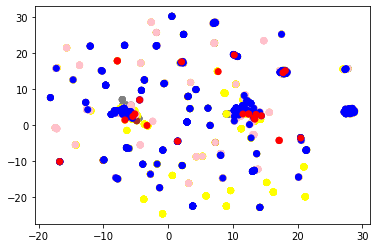

In [55]:
# print(X2.shape)
color = ['grey', 'yellow', 'brown', 'pink', 'blue', 'red', 'magenta', 'purple', 'orange', 'cyan', 'olive']
c = [color[int(clrs[i])] for i in range(len(clrs))]
plt.scatter(X2[:,0], X2[:,1], color = c)
# plt.show()
plt.savefig("april.png")
files.download("april.png") 